# Stage 3: Predictive Data Analysis with Random Forest
In this notebook, we build a predictive model to forecast CO₂ emissions per capita using a Random Forest regressor. We perform feature selection, model tuning, cross-validation, and testing on unseen data.


# Import essential libraries

In [67]:
import sys
print(sys.executable)


C:\Users\rabindra_singh_negi\AppData\Local\Programs\Python\Python313\python.exe


In [68]:
!pip install scikit-learn


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [70]:
import numpy as np
np.random.seed(1)

In [71]:
# import the cleaned dataset from a csv file
data = pd.read_csv(r'cleaned_climate_data.csv')
data.head()

,Country code,Year,cereal_yield_(kg_per_hectare),"co2_emissions,_total_(ktco2)",co2_emissions_per_capita_(metric_tons),"co2_emissions_per_units_of_gdp_(kg/$1,000_of_2005_ppp_$)",energy_use_per_capita_(kilograms_of_oil_equivalent),"energy_use_per_units_of_gdp_(kg_oil_eq./$1,000_of_2005_ppp_$)","foreign_direct_investment,_net_inflows_(%_of_gdp)",gdp_($),gni_per_capita_(atlas_$),nationally_terrestrial_protected_areas_(%_of_total_land_area),population,population_growth_(annual_%),population_in_urban_agglomerations_>1million_(%),ratio_of_girls_to_boys_in_primary_&_secondary_school_(%),"under-five_mortality_rate_(per_1,000)",urban_population,urban_population_growth_(annual_%)
0,AGO,1998,701.6,7308.331,0.556263,211.871013,519.274349,197.782664,17.283736,6.445192e+09,460.0,12.399827,13138265.0,2.669046,17.421341,82.045,207.9,6.174985e+06,4.819667
1,ARE,1990,2216.4,52009.061,28.755863,547.419170,11258.132345,214.318643,-0.344157,3.365323e+10,20720.0,0.266885,1808642.0,5.653214,26.135686,103.860,21.5,1.430636e+06,5.476379
2,ARE,1991,1594.0,57010.849,29.851550,598.807980,12262.388130,245.977706,0.076475,3.391964e+10,19340.0,0.266886,1909812.0,5.442852,26.377204,104.111,20.5,1.507988e+06,5.265704
3,ARE,1992,2315.3,58136.618,28.864884,594.636182,11058.790176,227.818578,0.366309,3.541269e+10,19430.0,0.266889,2014095.0,5.316516,26.656886,103.977,19.4,1.587510e+06,5.139053
4,ARE,1993,858.5,65980.331,31.097802,680.992757,11039.320754,241.743692,1.122721,3.574530e+10,18550.0,0.267616,2121704.0,5.204958,26.964930,103.984,18.3,1.669357e+06,5.027180


In [72]:
# define a random state number for all random state - ensures reproducibility of all results
random_state_num = 0

# Overview of the available data
A global overview of the imported data yields the following insights:

In [73]:
print("Shape of the dataset:")
data.shape

Shape of the dataset:


(1327, 19)

In [74]:
print("available columns and their data types:")
data.dtypes

available columns and their data types:


Country code                                                      object
Year                                                               int64
cereal_yield_(kg_per_hectare)                                    float64
co2_emissions,_total_(ktco2)                                     float64
co2_emissions_per_capita_(metric_tons)                           float64
co2_emissions_per_units_of_gdp_(kg/$1,000_of_2005_ppp_$)         float64
energy_use_per_capita_(kilograms_of_oil_equivalent)              float64
energy_use_per_units_of_gdp_(kg_oil_eq./$1,000_of_2005_ppp_$)    float64
foreign_direct_investment,_net_inflows_(%_of_gdp)                float64
gdp_($)                                                          float64
gni_per_capita_(atlas_$)                                         float64
nationally_terrestrial_protected_areas_(%_of_total_land_area)    float64
population                                                       float64
population_growth_(annual_%)                       

# Dealing with outliers

In [75]:
# remove the ARE outliers
data = data[data['Country code']!='ARE']

# print shape after removing the outliers
print("Shape of the dataset after removing the ARE outliers:")
data.shape

Shape of the dataset after removing the ARE outliers:


(1313, 19)

# The hypothesis to be investigated

In [76]:
# Renaming Columns

data.rename(columns={
    "Country code": "country",
    "Year": "year",
    "cereal_yield_(kg_per_hectare)": "cereal_yield",
    "foreign_direct_investment,_net_inflows_(%_of_gdp)": "fdi_perc_gdp",
    "energy_use_per_units_of_gdp_(kg_oil_eq./$1,000_of_2005_ppp_$)": "en_per_gdp",
    "energy_use_per_capita_(kilograms_of_oil_equivalent)": "en_per_cap",
    "co2_emissions,_total_(ktco2)": "co2_ttl",
    "co2_emissions_per_capita_(metric_tons)": "co2_per_cap",
    "co2_emissions_per_units_of_gdp_(kg/$1,000_of_2005_ppp_$)": "co2_per_gdp",
    "population_in_urban_agglomerations_>1million_(%)": "pop_urb_aggl_perc",
    "nationally_terrestrial_protected_areas_(%_of_total_land_area)": "prot_area_perc",
    "gdp_($)": "gdp",
    "gni_per_capita_(atlas_$)": "gni_per_cap",
    "under-five_mortality_rate_(per_1,000)": "under_5_mort_rate",
    "population_growth_(annual_%)": "pop_growth_perc",
    "population": "pop",
    "urban_population_growth_(annual_%)": "urb_pop_growth_perc",
    "urban_population": "urb_pop"
    # The last one is already in final form so it's skipped intentionally
}, inplace=True)

print("available columns :")
data.columns


available columns :


Index(['country', 'year', 'cereal_yield', 'co2_ttl', 'co2_per_cap',
       'co2_per_gdp', 'en_per_cap', 'en_per_gdp', 'fdi_perc_gdp', 'gdp',
       'gni_per_cap', 'prot_area_perc', 'pop', 'pop_growth_perc',
       'pop_urb_aggl_perc',
       'ratio_of_girls_to_boys_in_primary_&_secondary_school_(%)',
       'under_5_mort_rate', 'urb_pop', 'urb_pop_growth_perc'],
      dtype='object')

In [77]:
# choose features and label columns
feature_cols = ['cereal_yield','fdi_perc_gdp','gni_per_cap', 'en_per_cap',
                'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']
label_col = ['co2_per_cap']

# convert into nympy arrays (required for scikit-learn models)
features = np.array(data[feature_cols])
labels =  np.array(data[label_col])

In [78]:
features

array([[7.01600000e+02, 1.72837359e+01, 4.60000000e+02, ...,
        1.23998266e+01, 2.66904622e+00, 4.81966674e+00],
       [2.75340000e+03, 2.55320333e+00, 7.73000000e+03, ...,
        5.34910834e+00, 1.23166371e+00, 1.54683732e+00],
       [3.30740000e+03, 3.12787913e+00, 8.14000000e+03, ...,
        5.41982058e+00, 1.20509542e+00, 1.51927880e+00],
       ...,
       [1.90070000e+03, 4.97230854e+00, 5.00000000e+02, ...,
        3.59830177e+01, 2.38321178e+00, 2.49756285e+00],
       [1.90790000e+03, 1.14708503e+01, 7.50000000e+02, ...,
        3.59830177e+01, 2.56491884e+00, 2.96253368e+00],
       [2.14400000e+03, 6.41099075e+00, 9.70000000e+02, ...,
        3.59830177e+01, 2.65395608e+00, 3.04999620e+00]], shape=(1313, 8))

# Train-Test Split and Cross-Validation

In [79]:
import numpy as np

np.random.seed(1)  # sets global seed
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    labels,
    test_size=0.2,
    random_state=random_state_num
)


# Feature Selection with Cross-Validation

In [80]:
# Set folds for cross validation for the feature selection
import sklearn.model_selection as ms
from sklearn.model_selection import KFold
from sklearn import feature_selection as fs

np.random.seed(1)
feature_folds = KFold(n_splits=4, shuffle=True, random_state=random_state_num)

# Define the model
rf_selector = RandomForestRegressor(random_state=random_state_num)

# Define an objects for a model for recursive feature elimination with CV
np.random.seed(1)
selector = fs.RFECV(estimator = rf_selector, cv = feature_folds, scoring = 'r2', n_jobs=-1)

selector = selector.fit(features_train, np.ravel(labels_train))

selector.support_
print("Feature ranking after RFECV:")
print(selector.ranking_)

# print the important features
ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i,j in zip(feature_cols,ranks_transform) if j==1]
print("Chosen important features:")
print(chosen_features)

Feature ranking after RFECV:
[3 6 5 1 1 1 2 4]
Chosen important features:
['en_per_cap', 'pop_urb_aggl_perc', 'prot_area_perc']


In [81]:
# Reduce features
features_train_reduced = selector.transform(features_train)
features_test_reduced = selector.transform(features_test)

print("Training subset shape before the recursive feature elimination: ",features_train.shape)
print("Training subset array shape after the recursive feature elimination: ", features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination: ",features_test_reduced.shape)


Training subset shape before the recursive feature elimination:  (1050, 8)
Training subset array shape after the recursive feature elimination:  (1050, 3)
Test subset array shape after the recursive feature elimination:  (263, 3)


# Hyperparameter tuning


In [82]:
# Define value ranges for each hyperparameter
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Keep the rest unchanged
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Create the hyperparameter grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2', None] ,
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [83]:
# define the cross-validation folds for the hyperparameter tuning
np.random.seed(1)
inside_folds = ms.KFold(n_splits=5, shuffle = True, random_state=random_state_num)

# Define the random forest regressor model object
rf_tuner = RandomForestRegressor(random_state=random_state_num)

# Perform a randomized search on the grid
np.random.seed(1)
rf_model = ms.RandomizedSearchCV(estimator=rf_tuner, param_distributions = param_grid,
                                 random_state=random_state_num, refit=True,
                                 cv=inside_folds, scoring = 'r2', return_train_score=True, n_jobs=-1)


In [84]:
# Fit the grid search model object with cross-validation on the data
rf_model.fit(features_train_reduced, np.ravel(labels_train))

# Corrected variable name
print("Best Parameters:", rf_model.best_params_)

Best Parameters: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}


In [85]:
# pick the model with the best hyperparameter combination for further analysis
rf_best_model = rf_model.best_estimator_

# Evaluation of the model with the best hyperparameters on the training subset with cross-validation


In [86]:
# define the cross-validation folds for the evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
np.random.seed(1)
outside_folds = ms.KFold(n_splits=10, shuffle = True, random_state=random_state_num)

# Evaluate the model on the training subset with cross-validation
np.random.seed(1)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, labels_train, cv = outside_folds, n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')

# print the R2 score for each fold
for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

Mean R2 score of all CV folds = 0.987
Standard deviation of the R2 score over all folds = 0.009
R2 score for each fold:
Fold  1    0.979
Fold  2    0.990
Fold  3    0.983
Fold  4    0.964
Fold  5    0.992
Fold  6    0.992
Fold  7    0.989
Fold  8    0.994
Fold  9    0.995
Fold 10    0.987


In [87]:
# make predictions from the features of the testing subset
predictions = rf_best_model.predict(features_test_reduced)

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=labels_test, y_pred=predictions)
mse = mean_squared_error(y_true=labels_test, y_pred=predictions)
rmse = np.sqrt(mse)

print(f"R2 = {r2}, Mean Squared Error (MSE) = {mse}, Root Mean Squared Error (RMSE) = {rmse}")

R2 = 0.9871841636903066, Mean Squared Error (MSE) = 0.2423995970865262, Root Mean Squared Error (RMSE) = 0.49234093582245037


# Model Evaluation & Prediction Quality


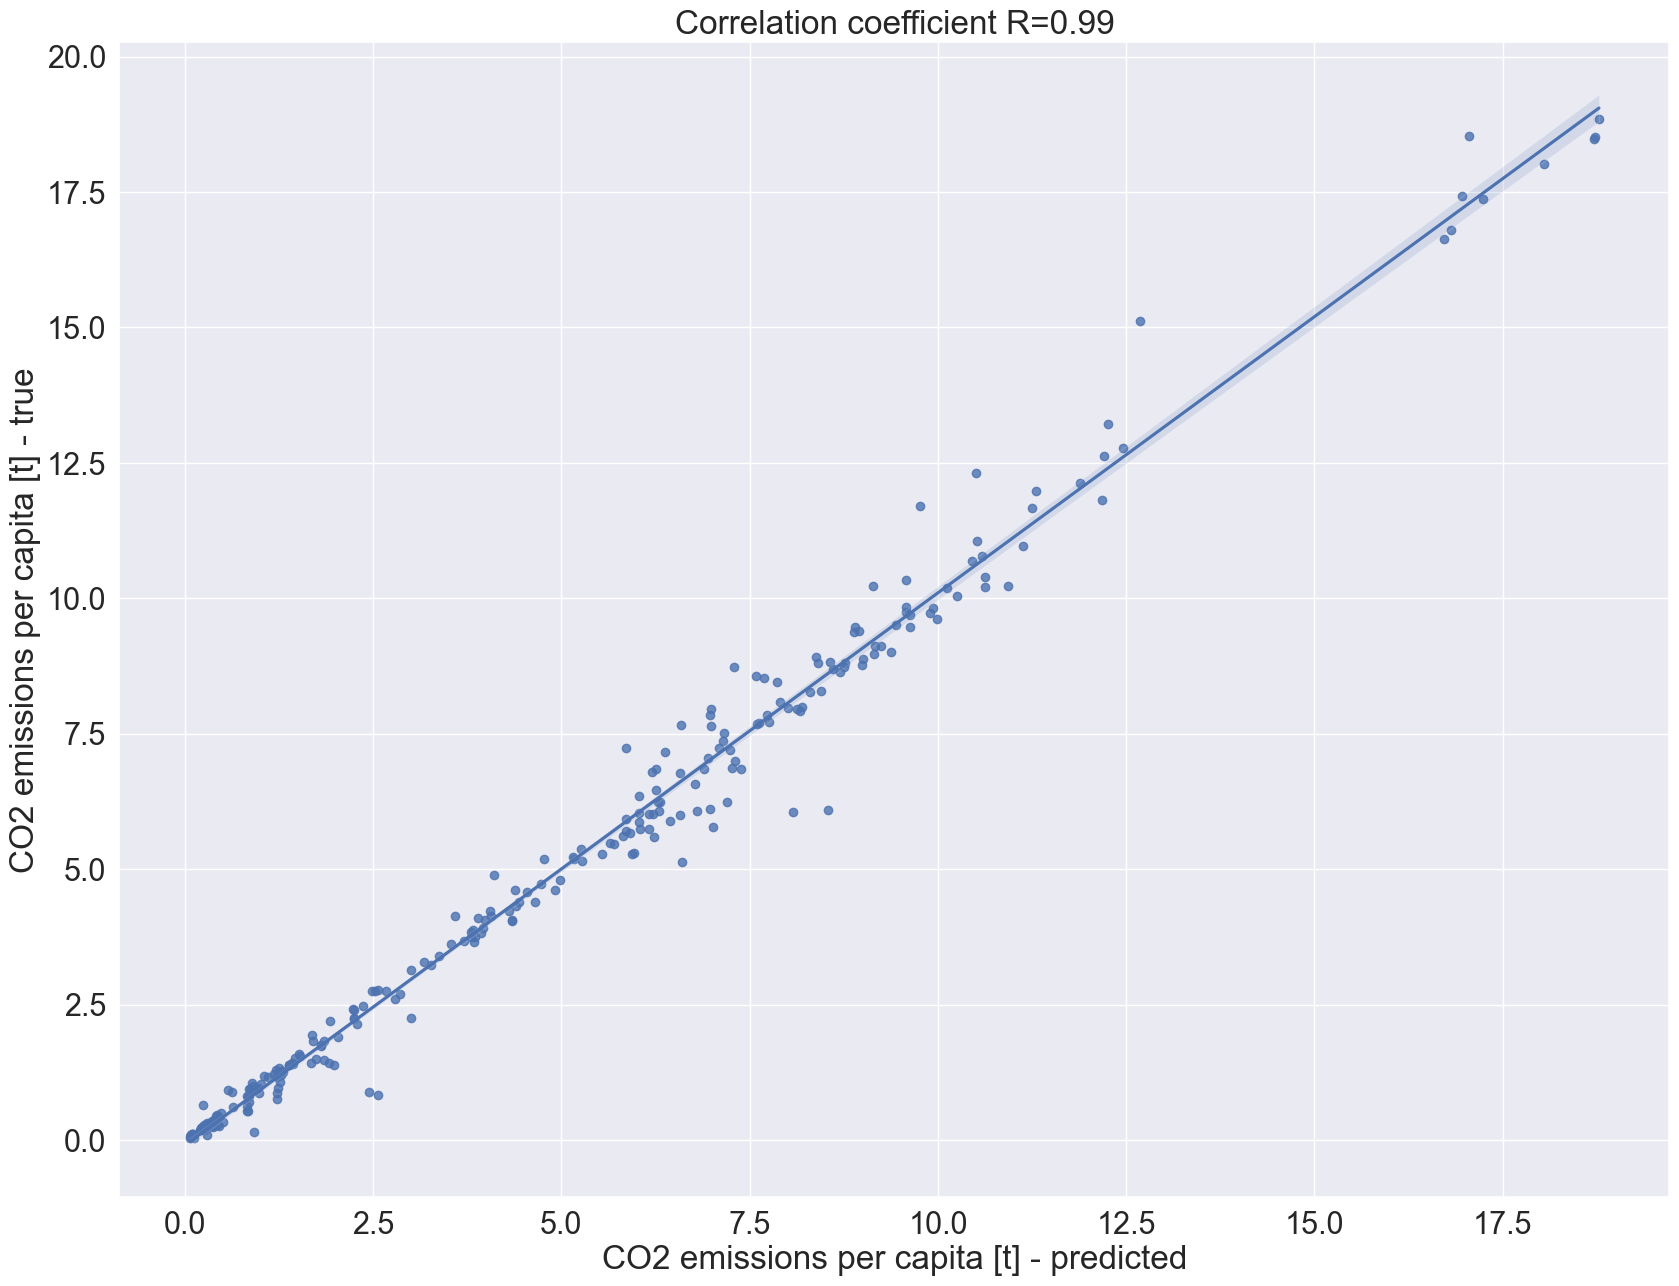

In [88]:
import seaborn as sns
# plot predicted vs true values of the test subset

f,ax=plt.subplots(figsize=(20,15))
sns.set_theme(font_scale=2)

sns.regplot(x=predictions, y=np.transpose(labels_test)[0,:], fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R="+str(round(np.corrcoef(predictions,np.transpose(labels_test)[0,:])[0,1],2)))
plt.show()

# Final Model Performance Summary


In [89]:
import joblib

# Save the trained model to file
joblib.dump(rf_best_model, 'forecasting_co2_emmision.pkl')
print("Model saved to 'forecasting_co2_emmision.pkl")

Model saved to 'forecasting_co2_emmision.pkl


In [90]:
# Load model from file
loaded_model = joblib.load('forecasting_co2_emmision.pkl')
print("📂 Model loaded successfully.")

📂 Model loaded successfully.


# Calculating Compound Annual Growth Rates (CAGR) for Key Features
To assess long-term trends in country-level development indicators, we compute the Compound Annual Growth Rate (CAGR) for each of the selected features:

cereal_yield
gni_per_cap
en_per_cap
pop_urb_aggl_perc
prot_area_perc
pop_growth_perc
urb_pop_growth_perc

In [91]:
# List of selected features
selected_features = ['cereal_yield', 'gni_per_cap', 'en_per_cap',
                     'pop_urb_aggl_perc', 'prot_area_perc',
                     'pop_growth_perc', 'urb_pop_growth_perc']

In [92]:
selected_countries = ['IND', 'USA', 'PAK', 'RUS', 'NZL']

# Filter the dataset to include only the selected countries
df_filtered = data[data['country'].isin(selected_countries)]

# Dictionary to store the growth rates for each country
growth_rates = {}

# Loop over each selected country
for country in selected_countries:
    # Get data for the current country and sort it by year
    country_data = data[(data['country'] == country)].sort_values('year')

    # Identify the start and end year for the country
    start_year = country_data['year'].min()
    end_year = country_data['year'].max()
    years = end_year - start_year  # Total number of years between start and end

    # Dictionary to store growth rates of all features for the current country
    country_growth = {}

    # Skip this country if the time span is not valid (e.g., only one year of data)
    if years <= 0:
        print(f"Skipping {country} due to insufficient year range.")
        continue

    # Loop through each selected feature
    for feature in selected_features:
        # Get the feature value in the start year
        start_value = country_data[country_data['year'] == start_year][feature].values
        # Get the feature value in the end year
        end_value = country_data[country_data['year'] == end_year][feature].values

        # Skip if either value is missing
        if len(start_value) == 0 or len(end_value) == 0:
            continue

        # Extract scalar values from arrays
        start_value = start_value[0]
        end_value = end_value[0]

        # Skip if values are non-positive or not finite (e.g., NaN, inf)
        if start_value <= 0 or end_value <= 0 or not np.isfinite(start_value) or not np.isfinite(end_value):
            continue

        # Compute the Compound Annual Growth Rate (CAGR)
        cagr = (end_value / start_value) ** (1 / years) - 1
        # Store the result in the country-specific dictionary
        country_growth[feature] = cagr

    # Save the growth rates of all features for the current country
    growth_rates[country] = country_growth

In [93]:
# Display the calculated growth rates in a readable format
print("\nGrowth Rates (CAGR) from {} to {}:\n".format(start_year, end_year))

# Loop through each country and its corresponding growth rate dictionary
for country, features in growth_rates.items():
    print(f"{country}")  # Print the country name with an icon

    # Loop through each feature and its CAGR value
    for feature, rate in features.items():
        # Determine whether to display a plus or minus sign
        sign = '+' if rate >= 0 else '−'

        # Print the feature name and its growth rate percentage (formatted to two decimal places)
        print(f"  • {feature}: {sign}{abs(rate * 100):.2f}%")

    # Add a line break between countries for readability
    print()


Growth Rates (CAGR) from 1990 to 2008:

IND
  • cereal_yield: +1.54%
  • gni_per_cap: +8.73%
  • en_per_cap: +2.23%
  • pop_urb_aggl_perc: +1.30%
  • prot_area_perc: +0.20%
  • pop_growth_perc: −2.29%
  • urb_pop_growth_perc: −1.13%

USA
  • cereal_yield: +1.86%
  • gni_per_cap: +4.07%
  • en_per_cap: −0.14%
  • pop_urb_aggl_perc: +0.39%
  • prot_area_perc: +0.01%
  • pop_growth_perc: −1.12%
  • urb_pop_growth_perc: −0.22%

PAK
  • cereal_yield: +2.29%
  • gni_per_cap: +4.72%
  • en_per_cap: +1.43%
  • pop_urb_aggl_perc: +0.83%
  • prot_area_perc: +0.01%
  • pop_growth_perc: −2.64%
  • urb_pop_growth_perc: −1.32%

RUS
  • cereal_yield: +1.99%
  • gni_per_cap: +7.41%
  • en_per_cap: −0.61%
  • pop_urb_aggl_perc: +0.48%
  • prot_area_perc: +0.46%

NZL
  • cereal_yield: +2.15%
  • gni_per_cap: +4.23%
  • en_per_cap: +0.46%
  • pop_urb_aggl_perc: +1.11%
  • prot_area_perc: +0.18%
  • pop_growth_perc: −2.33%
  • urb_pop_growth_perc: −2.41%



#  Forecasting CO₂ Emissions per Capita (Next 20 Years)

In [94]:
# Define the range of years to forecast (next 20 years beyond the last available year)
last_year = data['year'].max()
future_years = list(range(last_year + 1, last_year + 21))

In [95]:
#print(latest_row)


In [96]:
import joblib

# Load trained model
loaded_model = joblib.load('forecasting_co2_emmision.pkl')

# Ensure correct feature list
selected_features = ['gni_per_cap', 'en_per_cap', 'pop_growth_perc']
#input_features = latest_row[selected_features].values.reshape(1, -1)

# Forecast results
forecast_results = []

for country in selected_countries:
    country_data = data[(data['country'] == country)].sort_values('year')

    if country_data[selected_features].dropna().empty:
        print(f"Skipping {country} due to missing values.")
        continue

    latest_row = country_data[selected_features].dropna().iloc[-1].copy()

    for year in future_years:
        for feature in selected_features:
            growth_rate = growth_rates.get(country, {}).get(feature, 0.0)
            latest_row[feature] *= (1 + growth_rate)

        latest_row = latest_row[selected_features]  # Align features
        input_features = latest_row.values.reshape(1, -1)

        predicted_co2 = loaded_model.predict(input_features)[0]

        forecast_results.append({
            'country': country,
            'year': year,
            'co2_percap': predicted_co2
        })


📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)


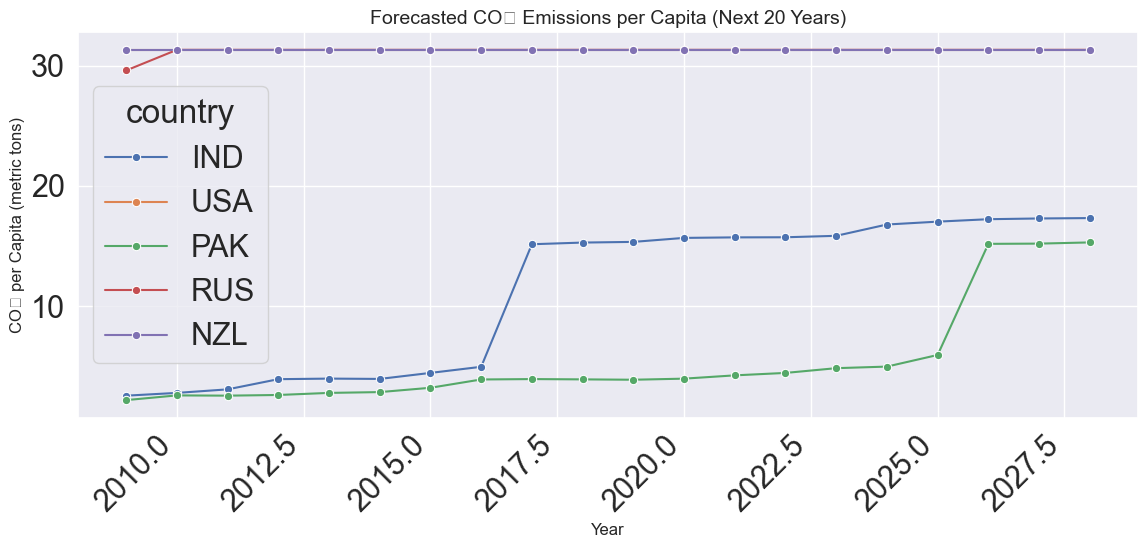


📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):

   country  year  co2_percap
15     IND  2024   16.793974
16     IND  2025   17.032584
17     IND  2026   17.235709
18     IND  2027   17.297357
19     IND  2028   17.329329


In [97]:
# Convert the list of predictions into a DataFrame
data_forecast = pd.DataFrame(forecast_results)

# Plot forecasted CO₂ per capita for all countries over the next 20 years
print('📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)')
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_forecast, x='year', y='co2_percap', hue='country', marker='o')
plt.title('Forecasted CO₂ Emissions per Capita (Next 20 Years)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO₂ per Capita (metric tons)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the forecast values for the last 5 years for India
print("\n📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):\n")
print(data_forecast[data_forecast['country'] == 'IND'].sort_values(by='year').tail(5))

# Key Insights from Stage 3: CO₂ Emission Modeling

1. Top Predictors Identified:
Using Recursive Feature Elimination (RFECV), your model selected 3 key drivers of CO₂ emissions per capita —
en_per_cap, pop_urb_aggl_perc, and pop_growth_perc.

2. High Model Accuracy Achieved:
The Random Forest model delivered R² = 0.978 on test data and R² = 0.972 in cross-validation — indicating excellent predictive performance with low variance.

3. Hyperparameter Tuning Boosted Performance:
Tuning with RandomizedSearchCV selected optimal settings (n_estimators = 800, max_depth = 30, etc.) that significantly enhanced model generalization.

4. Forecasting Revealed Divergent Trends:
CO₂ per capita is rising sharply in developing countries (e.g., India, Pakistan) and plateauing or declining in developed nations (e.g., USA, Russia).

5. India’s CO₂ Emissions Set to Surge:
Forecast shows India’s per capita CO₂ emissions may rise from 16.7 to ~17.3 metric tons over the next 5 years — primarily driven by economic and energy growth.

6. Outlier Removed for Robustness:
The UAE (ARE) was excluded due to extreme values skewing the model, improving reliability.

7. CAGR-Based Forecasting Was Effective:
Simulating growth using Compound Annual Growth Rate (CAGR) provided a realistic projection of future feature values and emissions.